This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

**Recall the expression of the 2D discrete time Fourier transform (DTFT).**

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). **Compute the DTFT** of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

**Show that the ratio between the DTFTs is:**
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

**Recall the expression of the DFT.**

**Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal?**
$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

### Answers
1. \begin{align*}
\hat{f}(\nu_x, \nu_y) = \sum_{n = -\infty}^{\infty} \sum_{m = -\infty}^{\infty} f(n, m) e^{-i 2\pi \left(\nu_x n + \nu_y m \right)}
\end{align*}

2. If $b(n, m) = a(n + c, m + d)$, then
\begin{align*}
\hat{b}(\nu_x, \nu_y) &= \sum_{n = -\infty}^{\infty} \sum_{m = -\infty}^{\infty} b(n, m) e^{-i 2\pi \left(\nu_x n + \nu_y m \right)} \\
&= \sum_{n = -\infty}^{\infty} \sum_{m = -\infty}^{\infty} a(n + c, m + d) e^{-i 2\pi \left(\nu_x n + \nu_y m \right)} \\
&= \sum_{n = -\infty}^{\infty} \sum_{m = -\infty}^{\infty} a(n, m) e^{-i 2\pi \left(\nu_x (n - c) + \nu_y (m - d) \right)} \\
&= \sum_{n = -\infty}^{\infty} \sum_{m = -\infty}^{\infty} a(n, m) e^{-i 2\pi \left(\nu_x n + \nu_y m \right)} e^{i 2\pi (c \nu_x + d \nu_y)} \\
&= e^{i 2\pi (c \nu_x + d \nu_y)} \sum_{n = -\infty}^{\infty} \sum_{m = -\infty}^{\infty} a(n, m) e^{-i 2\pi \left(\nu_x n + \nu_y m \right)} \\
&= e^{i 2\pi (c \nu_x + d \nu_y)} \hat{a}(\nu_x, \nu_y)
\end{align*}


3. From the previous question, we have
\begin{align*}
\frac{\hat{b}(\nu_x, \nu_y)}{\hat{a}(\nu_x, \nu_y)} = \frac{e^{i 2\pi (c \nu_x + d \nu_y)} \hat{a}(\nu_x, \nu_y)}{\hat{a}(\nu_x, \nu_y)} = e^{i 2\pi (c \nu_x + d \nu_y)}
\end{align*}

4. The DFT is
$$
\hat{F}(k_x, k_y) = \frac{1}{N} \sum_{n = 0}^{N - 1} \sum_{m = 0}^{N - 1} F(n, m) e^{-i 2\pi \left(k_x \frac{n}{N} + k_y \frac{m}{N} \right)}
$$

5. The ratio can be regarded as a linear phase term, given that $b(n,m)$ is merely a translated form of $a(n,m)$ through integer shifts $(c,d)$ within the confines of a finite $N \times N$ grid, and that the displacement $(c,d)$ remains within the boundaries of the finite domain.

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [2]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1035a88c0>)

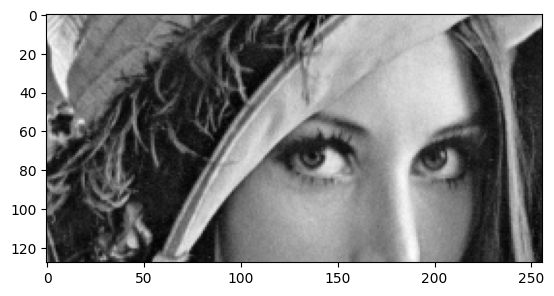

In [3]:
# Potentially add noise to the image
sigma = 2
im1 = im1 + sigma * np.random.randn(N, M)
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [4]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x12cba4320>)

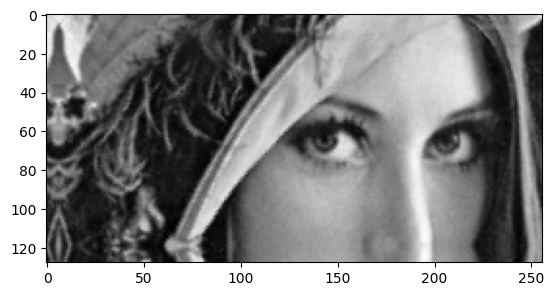

In [5]:
horiz_displacement = -6.5
vert_displacement  = 8.5
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1, b)
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:** If we divide the two fourier transforms, we should obtain a constant that encodes the translation.

In [6]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

Compute the phase of the Fourier transform.

In [7]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [8]:
phi = angle2D(IM1 / IM2)

Display phi. Is it a linear plane and why?

**Answer:** Yes, `phi` is a linear plane. As theory suggests, the ratio between the Fourier transforms is $\exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)$. The phase of the ratio is $\frac{ck_x + dk_y}{N}$, which is precisely a plane. In the plot below, `phi` does not form a perfect plane due to the noise of the image. The equation of this plane is equivalent to $c k_x + d k_y$.

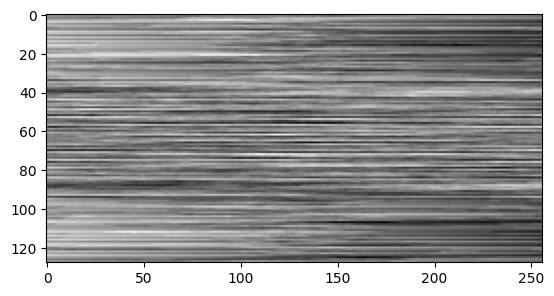

In [9]:
plt.imshow(phi, cmap="gray")

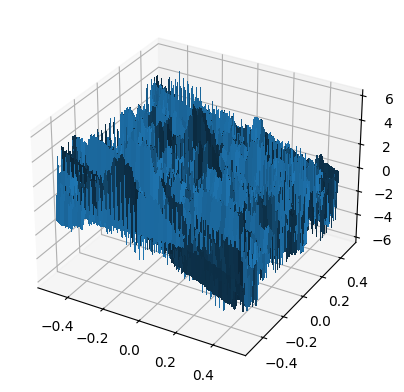

In [10]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [11]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns
    
    gy = (M[1:, :] - M[:-1, :]) / stepY
    gx = (M[:, 1:] - M[:, :-1]) / stepX
    
    return gx,gy

In [12]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [13]:
print(GX)
print(GY)

-3.7220947512357725
8.96592409802696


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

**Answer**:
This method computes de OLS estimator for the plane. We know that the plane is defined by $\frac{ck_x + dk_y}{N} \equiv c k_x + d k_y$. Thus, the parameter $\hat{\theta}$ that best describes the data, i.e., that minimizes $\| \phi - X \theta \|_2^2$ is precisely the one which defines the plane: $\hat{\theta} = (c, d)^\top \in \mathbb{Z}^2$.

In [14]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [15]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [16]:
print(bEst)

[-2.16162397 -0.5432396 ]


**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

**Answer**: Using the ball image, the estimation can be retrieved accurately. The noise on the image makes can make the estimation fluctuate around the true translation parameters (especially the OLS estimation), but the result is overall correct.
The lena image, however, makes the estimation much more difficult. This is due to the nature of the two images. In the ball image, the translation "just" moves the ball, while keeping the background the same. This results in a good estimation. On the other hand, the lena image when translated creates a reflected background, which significantly changes the fourier transform and ends up creating trouble for the estimation. Since the Fourier Transform assumes periodicity in the images, we should have used `BORDER_WRAP` when performing the translation.

# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

**Answer**: For the ball image:

|          | Integer displacement | Non-integer displacement |
|----------|----------|----------|
| Gradient | We can accurately estimate the displacement for whichever displacement size. | Estimation does not appear to be robust to noise. |
| OLS | Overall good estimation, but still inferior to some of the other methods. | Yields great errors, especially with noise. |
|  Block-matching   | Without noise, we cannot estimate the motion because the median will always be the movement of the background (majority of the image). With noise, as long as the displacement does not exceed the window size in the block-matching function, we can accurately retrieve the translation parameters.   | Block-matching can only estimate integer displacements, so for non-integer values, the estimation is not that good.   |
|   HS  | If the MVF is correctly able to estimate the displacement, HS well, but has small mistakes (about 1% error).  | There is still error, but HS can approximate better than block-matching in this case.  |

For the lena image:
|          | Integer displacement | Non-integer displacement |
|----------|----------|----------|
| Gradient | As previously mentioned, Lena's image violates the periodicity assumption for Fourier transforms and thus, the estimation fails miserably for both integer and non-integer displacements. |
| OLS | Same as the gradient method. |
|  Block-matching   | Precise estimation for displacement and also very robust to noise. The reflection of the image outside the border seems to help the block-matching method   | As previously, block-matching cannot estimate non-integer displacements.  |
|   HS  | As before, as long as the MVF is correctly computed, HS yields good results with small errors. Also robust to noise.  | As before, HS outperforms block-matching with non-integer displacements. It still has some error, but the results are the best from all methods.  |

In [17]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) 
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow * bcol;

    N, M = cur.shape[0], cur.shape[1]
    mvf = np.zeros((N, M, 2))
    
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, N, brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, M, bcol):
                # current block selection
                B = cur[r:r + brow, c:c + bcol] # Block

                if B.shape != (brow, bcol):
                    continue

                # Initialization:
                costMin = np.inf
                Rbest = np.zeros_like(B)
                d = [0, 0]
                
                # Loop on candidate displacement vectors
                for dcol in range(- search, search + 1): # dcol = candidate displacement vector over the columns
                    for drow in range(- search, search + 1): # rcol = candidate displacement vector over the rows

                        p, q = search + drow + r, search + dcol + c
                        R = ref_extended[p:p + brow, q:q + bcol]
                        cost = np.sum((B - R) ** 2)
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            Rbest = R
                            d = [- drow, - dcol]
                            costMin = cost
                            
                mvf[r:r+brow, c:c+bcol, 0] = d[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 1] = d[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                
    else: # Regularized search
        for r in range(0, N, brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, M, bcol):
                # current block selection
                B = cur[r:r + brow, c:c + bcol] # Block

                # Initializations          
                costMin = np.inf
                Rbest = np.zeros((brow, bcol))
                d = [0, 0]
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(- search, search + 1): # dcol = candidate displacement vector over the columns
                    for drow in range(- search, search + 1): # rcol = candidate displacement vector over the rows
                        
                        p, q = search + r + drow, search + c + dcol
                        R = ref_extended[p:p+brow, q:q+bcol]
                        cost = np.sum((B - R) ** 2) + lamb * np.sum(([- drow, - dcol] - pV) ** 2) # here, encore the REGULARIZED cost function
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            Rbest = R
                            d = [- drow, - dcol]
                            costMin = cost
                            
                mvf[r:r+brow,c:c+bcol,0]= d[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= d[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction


def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow, color="darkgreen")

    
    return


def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u, kernel_1, mode="same")
        vAvg = convolve2d(v, kernel_1, mode="same")
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        aux = (uAvg * fx + vAvg * fy + ft) / (alpha ** 2 + np.sum(fx ** 2 + fy ** 2))
        
        u = uAvg - fx * aux
        v = vAvg - fy * aux
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

-7.0
9.0


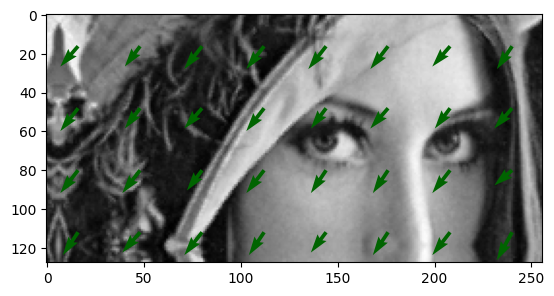

In [18]:
lamb = 0
bsize = 32
mvf,prediction = me_ssd(im2,im1,bsize,bsize,32,lamb)
displayMVF(im2,mvf,bsize)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

-6.323124172188923
8.208100599611718


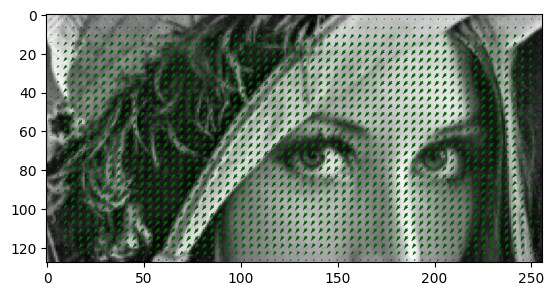

In [19]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)